In [33]:
%matplotlib inline

In [34]:
import numpy as np
import librosa
from librosa_ours import librosa as lib_ours
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import wavfile

In [35]:
### define file names
fileOne = "audio_data/Chopin_Mazurka_Op30_No2_1_mono.wav"
fileTwo = "audio_data/Chopin_Mazurka_Op30_No2_2_mono.wav"

In [36]:
### read in the two wav files
freqOne, audioOne = wavfile.read(fileOne)
freqTwo, audioTwo = wavfile.read(fileTwo)
audioOne = audioOne.astype(float)
audioTwo = audioTwo.astype(float)

//anaconda/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [37]:
### generate chroma features from the audio data
hopLength = 4096 # 4096 * (1/44100 s/sample) = 9.3ms
nFFT = 32768 # 32768 * (1/44100 s/sample) = 74 ms
featuresOne = librosa.feature.chroma_stft(y = audioOne, sr = freqOne, hop_length = hopLength)
featuresTwo = librosa.feature.chroma_stft(y = audioTwo, sr = freqTwo, hop_length = hopLength)

In [38]:
### normalize the chroma features by their L2 norm in each column
featuresOne = librosa.util.normalize(featuresOne, norm=2, axis=0)
featuresTwo = librosa.util.normalize(featuresTwo, norm=2, axis=0)

In [39]:
###  setup DTW parameters
stepSizes = np.array([[1,1], [1, 2], [2, 1]])
weights = np.array([2, 3, 3])

In [40]:
### Run normal DTW
accumCostNormal, warpingPathNormal = lib_ours.sequence.dtw(featuresOne, featuresTwo, metric='cosine', step_sizes_sigma = stepSizes, weights_mul = weights, forward_update=False)

In [41]:
### Run our look-forward DTW
accumCostForward, warpingPathForward = lib_ours.sequence.dtw(featuresOne, featuresTwo, metric='cosine', step_sizes_sigma = stepSizes, weights_mul = weights, forward_update=True)

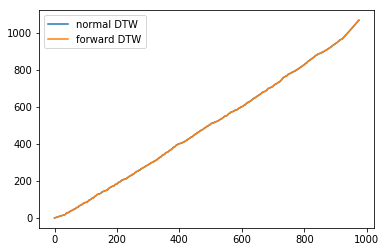

In [42]:
### Visualize both paths
plt.figure(0)
plt.plot([x for x, y in warpingPathNormal], [y for x, y in warpingPathNormal], label='normal DTW')
plt.plot([x for x, y in warpingPathForward], [y for x, y in warpingPathForward], label='forward DTW')
plt.legend()

In [43]:
### run subsequence DTW with each chunk, then plot in the correct location
def subsequenceDTWOnChunks(chunks):
    ###  setup DTW parameters
    stepSizes = np.array([1,1,1,2,2,1]).reshape((-1,2))
    weights = np.array([1,1,2])

    bestWarpingPaths = []
    accumCosts = [] # array of accumulated cost matrices
    warpingPaths = [] # array where each subarray contains the warping paths for a given chunk
    
    for chunkIndex in range(len(chunks)):
        accumCostChunk, bestWarpingPathChunk, stepMatrix = lib_ours.sequence.dtw(chunks[chunkIndex], featuresTwo, metric='cosine', step_sizes_sigma = stepSizes, weights_mul = weights, subseq=True, return_steps=True, forward_update=True)
        accumCosts.append(accumCostChunk)
        
        # adjust the best warping path to account for the chunk being in the middle of the piece
        adjustAmount = np.sum([x.shape[1] for x in chunks[:chunkIndex]])
        adjustedBestWarpingPath = [(row+adjustAmount,col) for (row,col) in bestWarpingPathChunk]
        bestWarpingPaths.append(adjustedBestWarpingPath)
        
        # find each of the warping paths for this chunk
        warpingPathsForChunk = []

        for lastFrameIndex in range(accumCosts[0].shape[1]):
            curWarpingPath = lib_ours.sequence.__dtw_backtracking(stepMatrix[:, :(lastFrameIndex+1)], stepSizes)
            adjustedCurWarpingPath = [(row+adjustAmount,col) for (row,col) in curWarpingPath]
            warpingPathsForChunk.append(adjustedCurWarpingPath)
        warpingPaths.append(warpingPathsForChunk)
        
            
    return bestWarpingPaths, accumCosts, warpingPaths

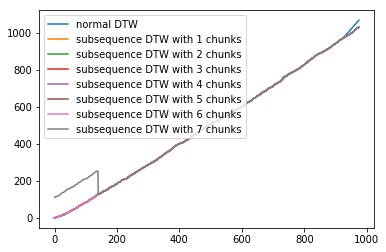

In [44]:
### split featuresOne into numChunks sub chunks
plt.figure(0)
plt.plot([x for x, y in warpingPathNormal], [y for x, y in warpingPathNormal], label='normal DTW')

for numChunks in range(1,8):
    plt.figure(0)
    chunks = np.array_split(featuresOne, numChunks, 1)
    bestWarpingPaths, accumCosts, warpingPaths = subsequenceDTWOnChunks(chunks)
    plt.plot([x for chunkPath in bestWarpingPaths[::-1] for x, y in chunkPath], [y for chunkPath in bestWarpingPaths[::-1] for x, y in chunkPath], label='subsequence DTW with {} chunks'.format(numChunks))
    plt.legend()
    
    '''
    # plot the warping paths for the first chunk
    plt.figure()
    for warpingPath in warpingPaths[-1]:
        plt.plot([x for x, y in warpingPath], [y for x, y in warpingPath])
    ''' 
    
plt.legend()

In [71]:
### run subsequence DTW on each chunk, get back all the needed warping paths, and the accumulated cost matrix
numChunks = 50
chunks = np.array_split(featuresOne, numChunks, 1)

bestWarpingPaths, accumCosts, warpingPaths = subsequenceDTWOnChunks(chunks)

(20, 1068)
[  48 1033]
49
1033
[  47 1003]
48
1003
[ 46 983]
47
983
[ 45 963]
46
963
[ 44 943]
45
943
[ 43 917]
44
917
[ 42 897]
43
897
[ 41 880]
42
880
[ 40 859]
41
859
[ 39 833]
40
833
[ 38 810]
39
810
[ 37 803]
38
803
[ 36 774]
37
774
[ 35 742]
36
742
[ 34 725]
35
725
[ 33 704]
34
704
[ 32 683]
33
683
[ 31 659]
32
659
[ 30 638]
31
638
[ 29 616]
30
616
[ 28 596]
29
596
[ 27 578]
28
578
[ 26 560]
27
560
[ 25 539]
26
539
[ 24 520]
25
520
[ 23 504]
24
504
[ 22 482]
23
482
[ 21 460]
22
460
[ 20 437]
21
437
[ 19 415]
20
415
[ 18 402]
19
402
[ 17 378]
18
378
[ 16 353]
17
353
[ 15 329]
16
329
[ 14 306]
15
306
[ 13 284]
14
284
[ 12 266]
13
266
[ 11 246]
12
246
[ 10 224]
11
224
[  9 205]
10
205
[  8 184]
9
184
[  7 166]
8
166
[  6 146]
7
146
[  5 103]
6
103
[  4 103]
5
103
[ 3 85]
4
85
[ 2 63]
3
63
[ 1 42]
2
42
[ 0 20]
1
20
16


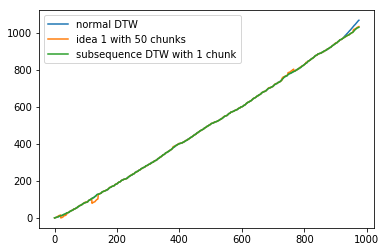

In [72]:
### Pull out the last frame from each subsequence cost matrix and put into a new matrix
print(accumCosts[0].
      shape)
lastCosts = np.zeros((len(accumCosts), accumCosts[0].shape[1]))

for chunkIndex in range(len(accumCosts)):
    lastCosts[chunkIndex,:] = accumCosts[chunkIndex][-1,:]
    
lastCosts[lastCosts==np.inf] = 9223372036854775807

stepSizes = np.array([1,0,0,1]).reshape((-1,2))
weights = np.array([1,0])

D, wp, stepMatrix = lib_ours.sequence.dtw(C=lastCosts, step_sizes_sigma = stepSizes, weights_mul = weights, subseq=True, return_steps=True)

backtrace = []
lastChunkIndex = wp[0][0] # the index of the last chunk
lastFrame = wp[0][1]

for elem in wp:
    # if the index changes, find the backtrace from this point
    if elem[0] != lastChunkIndex:
        backtrace.extend(warpingPaths[lastChunkIndex][lastFrame])
        print(elem)
        print(lastChunkIndex)
        print(lastFrame)
    lastChunkIndex = elem[0]
    lastFrame = elem[1]
    

# to add the backtrace for the first chunk
firstStepMatrix = stepMatrix[0,:]
firstStep = np.argwhere(firstStepMatrix!=-1)[0][0]
firstStep = firstStep - 1 # the real first step won't have a backtrace

print(firstStep)
backtrace.extend(warpingPaths[0][firstStep])

plt.figure(0)
plt.plot([x for x, y in warpingPathNormal], [y for x, y in warpingPathNormal], label='normal DTW')
plt.plot([x for x, y in backtrace], [y for x, y in backtrace], label='idea 1 with {} chunks'.format(numChunks))

# also plot subsequence with n = 1
chunks = np.array_split(featuresOne, 1, 1)
bestWarpingPaths, accumCosts, warpingPaths = subsequenceDTWOnChunks(chunks)
plt.plot([x for chunkPath in bestWarpingPaths[::-1] for x, y in chunkPath], [y for chunkPath in bestWarpingPaths[::-1] for x, y in chunkPath], label='subsequence DTW with 1 chunk')
    
plt.legend()